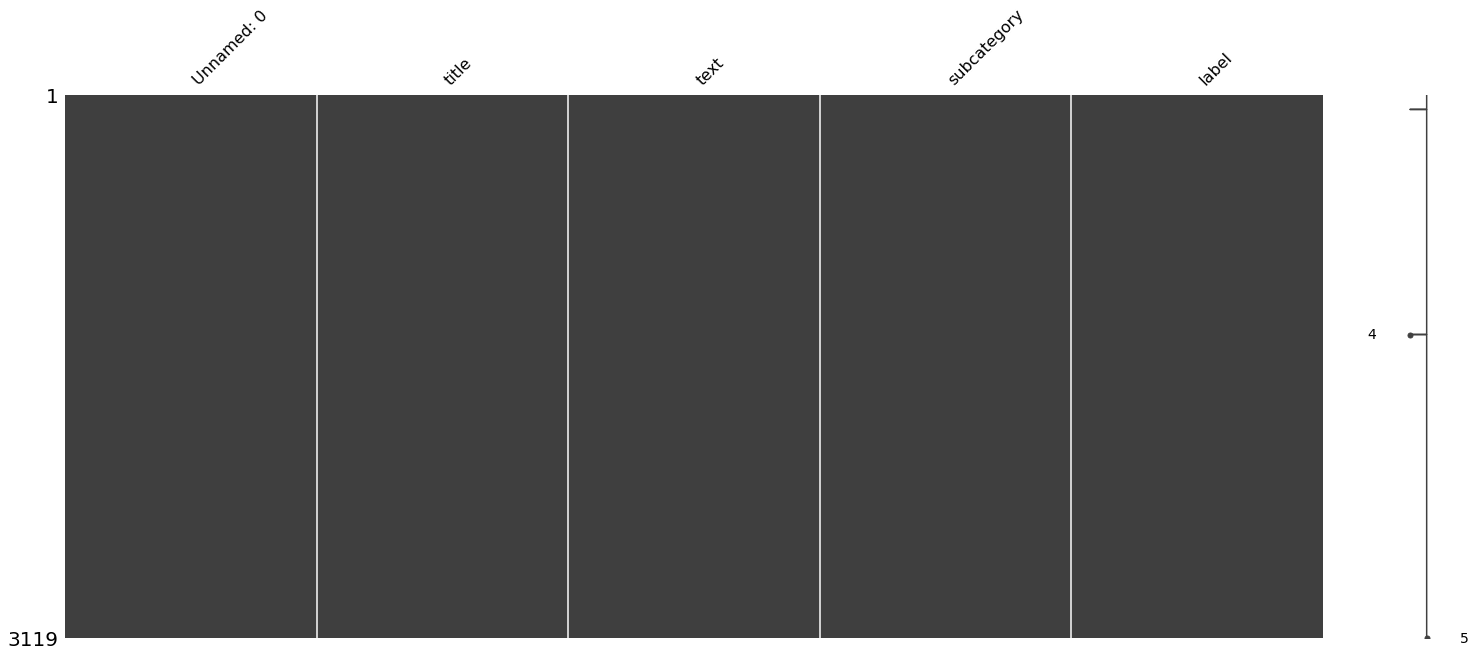

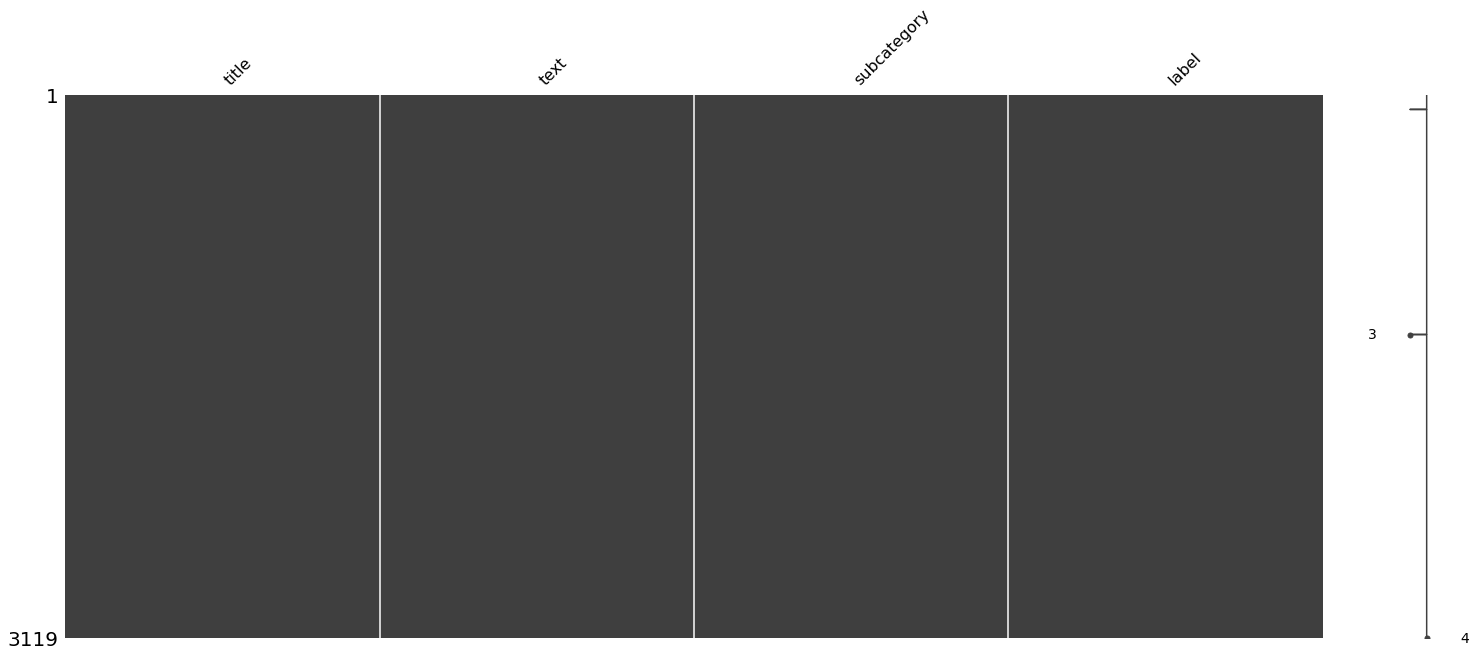

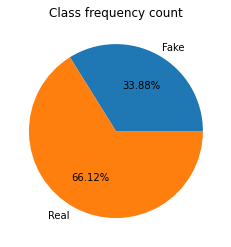

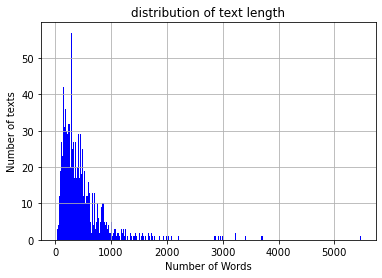

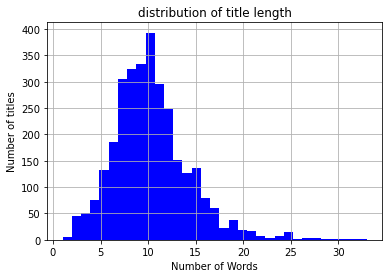

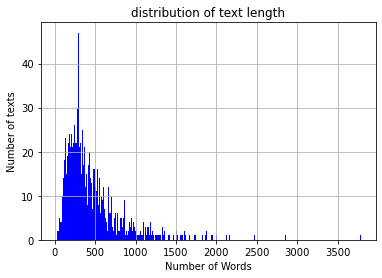

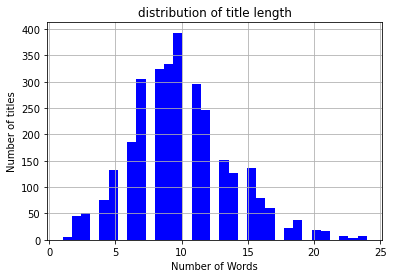

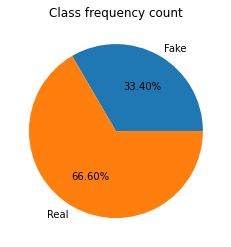

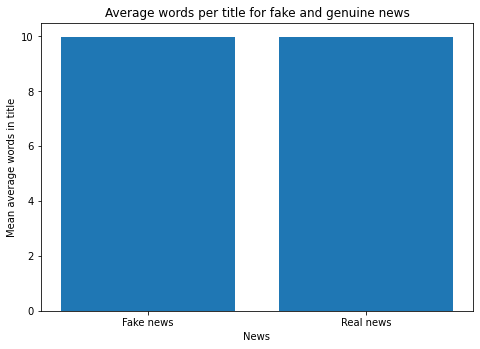

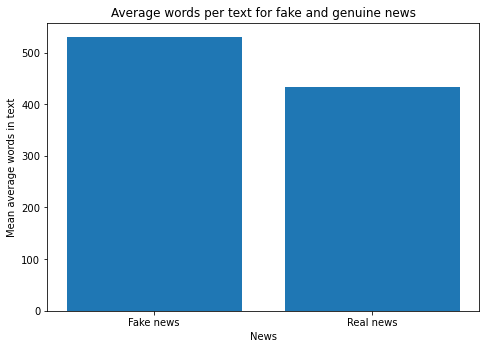

Counter({0: 2038, 1: 2038})


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import nltk.corpus
from nltk.corpus import stopwords




#import data set 
df = pd.read_csv('covid fake.csv')

#check for missing data and column names
msno.matrix(df)
df.head()

#drop irrelevent column 
df = df.drop(['Unnamed: 0'], axis=1)

msno.matrix(df)
df.head()


#Check which rows are missing 

df.count()

df.isnull().any(axis = 1).sum()


NaN_instances = df[df.isnull().any(axis=1)]
NaN_instances

#show entire instance 
pd.set_option("display.max_colwidth", None)

#drop missing rows 
df = df.drop(labels=[84,1375])

#check missing rows have been removed 
df.isnull().any(axis = 1).sum()

df.count()

#reset index
df = df.reset_index(drop=True)


#count number of words per feature and add two new columns 
df['total words of text'] = [len(x.split()) for x in df['text'].tolist()] # without counting punctuation 
df['total words of title'] = [len(x.split()) for x in df['title'].tolist()] # without counting punctuation


#create temp df to carry out visualization 
temp = df.groupby('label').count()
temp

#pie chart class frequency count
plt.figure()
labels = ['Fake','Real']
plt.pie(temp['title'],labels = labels, autopct = '%.2f%%')
plt.title('Class frequency count')
plt.show()


#hisotgram of the distribution text length  
word_count = [len(i.split()) for i in df['text']]

plt.figure()
pd.Series(word_count).hist(bins = 1000,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')
plt.title('distribution of text length')

#remove outliers 
temp = df.loc[df['total words of text'] >= 3000]
temp

df = df.drop(labels=[4,157,267,526,574,667,937,1244,1464,1513,1535,1794, 1806,
                    2070,2078, 2080, 2185, 3108, 2249, 2285, 2549, 2560, 2668, 2905, 2990])
df = df.reset_index(drop=True)

#histogram of the distribution of title length 

word_count = [len(i.split()) for i in df['title']]

plt.figure()
pd.Series(word_count).hist(bins = 33,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of titles')
plt.title('distribution of title length')


#remove outliers 
temp = df.loc[df['total words of title'] >= 25]
temp

df = df.drop(labels=[173, 204, 374, 468, 491, 588, 591, 641, 719, 726, 
                    1307, 1373, 1403, 1486, 1504, 1516, 1626, 1627, 1738, 1874, 1931, 3022,
                     1961, 1997, 2358, 2376, 2462, 2642, 2694, 2698, 2726])
df = df.reset_index(drop=True)

#check changes were made

#hisotgram of the distribution text length  
word_count = [len(i.split()) for i in df['text']]

plt.figure()
pd.Series(word_count).hist(bins = 1000,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')
plt.title('distribution of text length')

df = df.drop(labels=[3045])
df = df.reset_index(drop=True)

#histogram of the distribution of title length 

word_count = [len(i.split()) for i in df['title']]

plt.figure()
pd.Series(word_count).hist(bins = 33,color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Number of titles')
plt.title('distribution of title length')

#create temp df to carry out visualization 
temp = df.groupby('label').count()
temp

#pie chart class frequency count - remains virtually the same 
plt.figure()
labels = ['Fake','Real']
plt.pie(temp['title'],labels = labels, autopct = '%.2f%%')
plt.title('Class frequency count')
plt.show()

#average word counts per class
temp = df.groupby(['label']).mean()
temp.reset_index(inplace=True)

temp['label'].replace({0:'Fake news', 1:'Real news'}, inplace=True)

#bar plot - title
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = temp['label']
y = temp['total words of title']
ax.bar(x,y)
ax.set_title('Average words per title for fake and genuine news')
ax.set_ylabel('Mean average words in title')
ax.set_xlabel('News')

plt.show()

#bar plot - text
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

x = temp['label']
y = temp['total words of text']
ax.bar(x,y)
ax.set_title('Average words per text for fake and genuine news')
ax.set_ylabel('Mean average words in text')
ax.set_xlabel('News')

plt.show()

#remove unnecessary columns 

df = df.drop(['subcategory','total words of text', 'total words of title'],axis = 1)
df.head()

#creat x and y 
X = df.drop(['label'], axis = 1)
y = df['label']

#sampling methods 

#change over to under to change sampling method 
R_O_S= RandomOverSampler()
# resampling 
X_OS, y_OS = R_O_S.fit_resample(X, y)
# new class distribution 
print(Counter(y_OS))

y_OS = y_OS.to_frame(name='label')


#merge title with text 
X_OS['text']=X_OS['title']+X_OS['text']

X_OS['label'] = y_OS['label']

#merge title with text - drop title column no longer needed
df = X_OS
df= df.drop(['title'], axis = 1)


#data preprocessing 


#lower case 
df['text'] = df['text'].str.lower()

#remove numbers 

#the \d stands for 'anyt digit' and the + stands for one or more 
#this function  "Replace all occurring digits in the strings with nothing".

df['text'] = df['text'].str.replace('\d+', '')

#remove punctuation 
df['text'] = df['text'].str.replace(r'[^\w\s]+', '')


#stem words
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['text'] = df['text'].apply(stem_sentences)

#remove stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


#feature extraction 

x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.20, shuffle = True)
tfidf_vectorizer=TfidfVectorizer()

v_train =  tfidf_vectorizer.fit_transform(x_train.values.astype('U'))
v_test = tfidf_vectorizer.transform(x_test.values.astype('U'))




PAC Accuracy:82.6%
Accuracy: 82.6
Recall: 84.82
Precision: 79.41
F1-score: 82.03
C = 0.01 tol = 0.001 max_i = 200
C = 0.01 tol = 0.001 max_i = 500
C = 0.01 tol = 0.001 max_i = 1000
C = 0.01 tol = 0.001 max_i = 10000
C = 0.01 tol = 0.01 max_i = 200
C = 0.01 tol = 0.01 max_i = 500
C = 0.01 tol = 0.01 max_i = 1000
C = 0.01 tol = 0.01 max_i = 10000
C = 0.01 tol = 0.1 max_i = 200
C = 0.01 tol = 0.1 max_i = 500
C = 0.01 tol = 0.1 max_i = 1000
C = 0.01 tol = 0.1 max_i = 10000
C = 0.01 tol = 1 max_i = 200
C = 0.01 tol = 1 max_i = 500
C = 0.01 tol = 1 max_i = 1000
C = 0.01 tol = 1 max_i = 10000
C = 0.01 tol = 10 max_i = 200
C = 0.01 tol = 10 max_i = 500
C = 0.01 tol = 10 max_i = 1000
C = 0.01 tol = 10 max_i = 10000
C = 0.01 tol = 100 max_i = 200
C = 0.01 tol = 100 max_i = 500
C = 0.01 tol = 100 max_i = 1000
C = 0.01 tol = 100 max_i = 10000
C = 0.1 tol = 0.001 max_i = 200
C = 0.1 tol = 0.001 max_i = 500
C = 0.1 tol = 0.001 max_i = 1000
C = 0.1 tol = 0.001 max_i = 10000
C = 0.1 tol = 0.01 max_i =

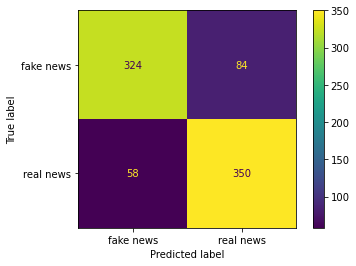

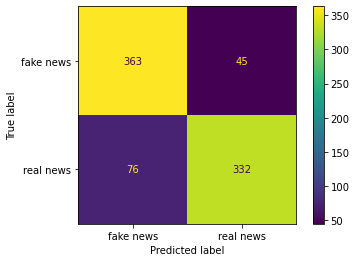

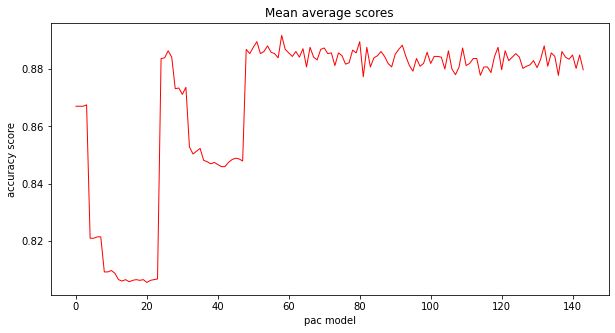

In [10]:
#PAC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

#baseline model
pac = PassiveAggressiveClassifier() 
pac.fit(v_train, y_train)

#baseline results 


y_predict = pac.predict(v_test)
score = accuracy_score(y_test, y_predict)
plot_confusion_matrix(pac,
                     v_test,
                     y_test,
                     display_labels = ["fake news", 'real news'])
print(f'PAC Accuracy:{round(score*100,2)}%')

print('Accuracy:', (round(accuracy_score(y_test,y_predict)*100,2)))
print('Recall:', (round(precision_score(y_test,y_predict, pos_label = 0)*100, 2)))
print('Precision:', (round(recall_score(y_test,y_predict, pos_label = 0)*100,2)))
print('F1-score:', (round(f1_score(y_test,y_predict, pos_label = 0)*100,2)))

#Tuning 
#hyper-parameters
C = [0.01, 0.1, 1, 10, 100, 1000]
tol = [0.001, 0.01, 0.1, 1, 10, 100]
max_iter = [200, 500, 1000, 10000]
c_1 = [] #C
tol_1 = [] #tolerance
mi_1 = [] #max iterations
score_1 = [] #score

X=tfidf_vectorizer.transform(df['text'].values.astype('U'))

for x in C:
    for i in tol:
        for u in max_iter:
            pac = PassiveAggressiveClassifier(C = x, max_iter = u, tol = i)
            pac.fit(v_train, y_train)
            scores = cross_val_score(pac, X, df['label'].values, cv=10)
            score = scores.mean()
            score_1.append(score)
            print(f'C = {x} tol = {i} max_i = {u}') # test tuning is working 
            c_1.append(x)
            tol_1.append(i)
            mi_1.append(u)
            

#optimised model

max_score = max(score_1)
max_score = float(max_score)
index_num = score_1.index(max_score) #index number for optimal parameters 

#optimised model 
pac = PassiveAggressiveClassifier(C = c_1[index_num], max_iter= mi_1[index_num],
                                  tol = tol_1[index_num])
pac.fit(v_train, y_train)

plot_confusion_matrix(pac,
                     v_test,
                     y_test,
                     display_labels = ["fake news", 'real news'])

#optimal hyper-parameters
print(f'Optimal C parameter: {c_1[index_num]}')
print(f'Optimal maximum iterations parameter: {mi_1[index_num]}')
print(f'Optimal tol: {tol_1[index_num]}')

y_predict = pac.predict(v_test)

#optimised results 
print(f'Accuracy Score : {(round(accuracy_score(y_test,y_predict)*100,2))}%')
print(f'Precision Score : {(round(precision_score(y_test,y_predict, pos_label = 0)*100, 2))}%')
print(f'Recall Score : {(round(recall_score(y_test,y_predict, pos_label = 0)*100,2))}%')
print(f'F1 Score : {(round(f1_score(y_test,y_predict, pos_label = 0)*100,2))}%')  

#tuning results - line graph 
ypoints = np.array(score_1)
plt.figure(figsize = (10,5))
plt.plot(ypoints, linestyle = 'solid', color = 'r', linewidth = 1)
plt.xlabel("pac model")
plt.ylabel("accuracy score")
plt.title('Mean average scores')
plt.show()